# Feature selection in high-dimensional genetic data

# Notebook 2: Linear regression, Lasso and Elastic Net

## Introduction

We keep on working with our _Arabidopsis thaliana_ data. We will now use various linear models to predict the phenotype from the genotype.

We start by reloading the same libraries and data as in Notebook 1, using the same code.

In [1]:
%pylab inline 
# imports matplotlib as plt and numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 14}) # font size for text on plots

In [3]:
import pandas as pd

In [4]:
# Loading the SNP names
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names))

9419


In [5]:
# Loading the design matrix -- this can take time!
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype = 'int') # values are integers
p = X.shape[1]

In [6]:
# Loading the samples
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype=int)) # values are integers

In [7]:
# Loading the phenotypes
df = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header=None, # columns have no header
                 delim_whitespace=True) # columns are separated by white space

In [8]:
# Loading the phenotypes
df_2W = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header=None, # columns have no header
                 delim_whitespace=True, # columns are separated by white space
                 index_col=0) # read the first column as index

# Create vector of sample IDs
samples_with_phenotype_2W = list(df_2W.index)
print(len(samples_with_phenotype_2W), "samples have a 2W phenotype")

# Create vector of phenotypes
y_2W = df_2W[1].to_numpy()

# Restricting the design matrix to those samples who have a 2W phenotype
X_2W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype_2W]), :]

# Delete X to free space
del X

152 samples have a 2W phenotype


In [9]:
# Loading the list of candidate genes
with open('data/athaliana.candidates.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

In [10]:
# Loading the SNPs-to-gene mapping
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/athaliana.snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

In [11]:
# Splitting the data into a train and test set
from sklearn import model_selection

X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W, test_size=0.2, 
                                     random_state=17) # use the same random_state as in Notebook 1 to obtain the same split
print(X_2W_tr.shape, X_2W_te.shape)

(121, 9419) (31, 9419)


## Linear regression 

### Fitting a linear regression to the training set

In [12]:
from sklearn import linear_model

In [13]:
model_lr = linear_model.LinearRegression(fit_intercept = True)
model_lr.fit(X_2W_tr, y_2W_tr)

LinearRegression()

We can now visualize the regression weights we have learned

(0.0, 9419.0)

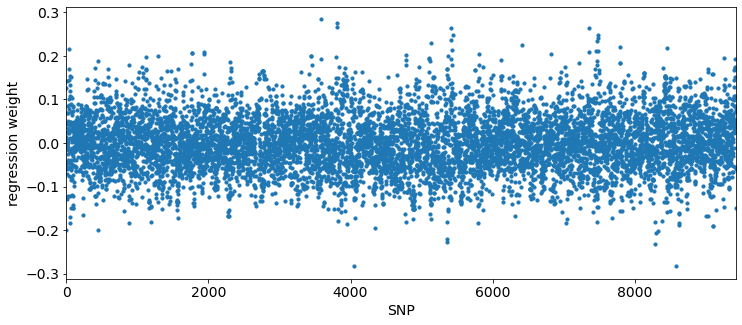

In [14]:
plt.figure(figsize = (12, 5))
plt.scatter(range(p), # x = SNP position
            model_lr.coef_, # y = regression weights
            s = 10)  # point size

plt.xlabel("SNP")
plt.ylabel("regression weight")
plt.xlim([0, p])

__Q: What do you observe? How can you interpret these results? Do any of the SNPs strike you as having a strong influence on the phenotype?__

The following SNPs are the ones with the ten highest weights (in absolute value). They are all near candidate genes.

In [15]:
highest_weights = np.abs(model_lr.coef_)
highest_weights.sort()
highest_weights = highest_weights[-10:]

for w in highest_weights:
    for snp_idx in np.where(model_lr.coef_ == w)[0]:
        print(w, snp_names[snp_idx])
        for gene_id in genes_by_snp[snp_names[snp_idx]]:
            if gene_id in candidate_genes:
                print("\t in/near candidate gene %s" % gene_id)

0.24035215582804081 Chr5_3185806_C
	 in/near candidate gene AT5G10140
0.24763507650157707 Chr5_3188327_T
	 in/near candidate gene AT5G10140
0.24771489625238546 Chr4_877075_T
	 in/near candidate gene AT4G02020
0.2644516112893104 Chr4_475593_A
	 in/near candidate gene AT4G01060
0.2651939999911171 Chr5_1168046_T
	 in/near candidate gene AT5G04240
0.26549584339865784 Chr3_1257380_C
	 in/near candidate gene AT3G04610
0.2757412462519856 Chr3_1256038_T
	 in/near candidate gene AT3G04610
0.28413213530874415 Chr2_19019256_T
	 in/near candidate gene AT2G46340


### Predictive power

In this section, we measure the performance of our model on the test dataset.

We will now look at the predictive power of the lasso estimated model.

__Q: What is the definition of the variance explained? You may use the [scikit learn documentation](https://sklearn.org/modules/classes.html#sklearn-metrics-metrics). What values can this metric take? and to what cases do the extreme values correspond to?__

__A:__ The explained variance is $1 - \frac{\text{variance of the residuals}}{\text{variance of the output}}$. It is equal to one in the case of a perfect fit (the residuals are all equal to zero, which can only happen with overfitting, and is therefore not desirable). A higher value means the genotype explains a large portion of the variability of the phenotype, which is good. It can be negative (in case of arbitrarily poor fits).

In [16]:
from sklearn import metrics

In [17]:
y_2W_lr_pred = model_lr.predict(X_2W_te)

print("Percentage of variance explained (using all SNPs): %.2f" % \
    metrics.explained_variance_score(y_2W_te, y_2W_lr_pred))

Percentage of variance explained (using all SNPs): 0.39


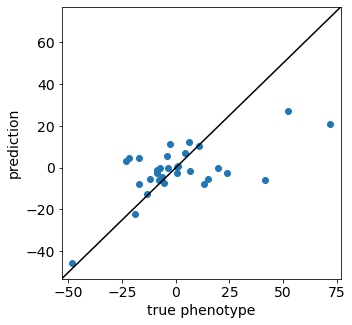

In [40]:
plt.figure(figsize = (5, 5))
plt.scatter(y_2W_te, y_2W_lr_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.ylim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.axline(xy1=[0, 0], slope=1, c="black")

## Lasso
Under the hypothesis that not all SNPs are involved in the phenotype, we will now attempt to learn a _sparse_ model, using a Lasso.

### Fitting a lasso model

Define a lasso model

In [19]:
lasso = linear_model.Lasso(fit_intercept=True, max_iter=6000)

Define cross-validation grid search and learn lasso with cross-validation.

In [20]:
alphas = np.logspace(-3., 2., num=20)
model_l1 = model_selection.GridSearchCV(lasso, param_grid = {'alpha': alphas}, 
                                        scoring='explained_variance', verbose=2)
model_l1.fit(X_2W_tr, y_2W_tr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................................alpha=0.001; total time=   3.2s
[CV] END ........................................alpha=0.001; total time=   2.9s
[CV] END ........................................alpha=0.001; total time=   3.0s
[CV] END ........................................alpha=0.001; total time=   2.8s
[CV] END ........................................alpha=0.001; total time=   2.8s
[CV] END ........................alpha=0.0018329807108324356; total time=   2.3s
[CV] END ........................alpha=0.0018329807108324356; total time=   2.5s
[CV] END ........................alpha=0.0018329807108324356; total time=   2.8s
[CV] END ........................alpha=0.0018329807108324356; total time=   2.7s
[CV] END ........................alpha=0.0018329807108324356; total time=   2.6s
[CV] END .........................alpha=0.003359818286283781; total time=   2.0s
[CV] END .........................alpha=0.00335

GridSearchCV(estimator=Lasso(max_iter=6000),
             param_grid={'alpha': array([1.00000000e-03, 1.83298071e-03, 3.35981829e-03, 6.15848211e-03,
       1.12883789e-02, 2.06913808e-02, 3.79269019e-02, 6.95192796e-02,
       1.27427499e-01, 2.33572147e-01, 4.28133240e-01, 7.84759970e-01,
       1.43844989e+00, 2.63665090e+00, 4.83293024e+00, 8.85866790e+00,
       1.62377674e+01, 2.97635144e+01, 5.45559478e+01, 1.00000000e+02])},
             scoring='explained_variance', verbose=2)

The best value of the regularization parameter is given by:

In [21]:
model_l1.best_params_

{'alpha': 0.0018329807108324356}

### Interpretation

Let us now visualize the regression coefficients:

(0.0, 9419.0)

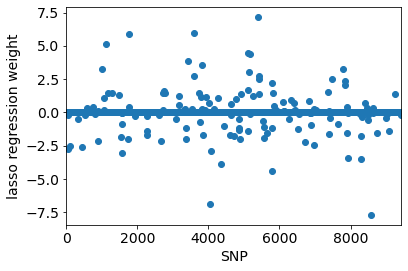

In [22]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("lasso regression weight")
plt.xlim([0, p])

__Q: How many SNPs are selected? How do you interpret this?__

In [23]:
# Answer:
selected_snps = np.nonzero(model_l1.best_estimator_.coef_)[0]
print("%d SNPs selected" % selected_snps.shape)

163 SNPs selected


__A:__ Only a small percentage of the 9419 SNPs have been estimated to have non-zero weights, and can hence be considered as selected and involved in flowering time.

We can now check whether those SNPs are in or near candidate genes, that is to say, genes that are known or strongly suspected to be involved in flowering time:

In [24]:
candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in selected_snps:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1
            break

print("%d of the selected SNPs are in or near %d candidate genes" % (num_snps_in_candidate_genes, 
                                                                     len(candidate_genes_hit)))

163 of the selected SNPs are in or near 87 candidate genes


All selected SNPs are in or near candidate genes. The lasso selected biologically relevant SNPs!

### Predictive power 

In [25]:
y_2W_l1_pred = model_l1.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1_pred)))

Percentage of variance explained (using 163 SNPs): 0.37


__Q: How does the lasso compare with the OLS (linear regression) in terms of variance explained? What is the advantage of the lasso model for generating biological hypotheses?__

__A:__ Compared to unpenalized linear regression (also called OLS), the Lasso has a similar variance explained, while using way fewer SNPs. So it is a better model: we need fewer mutations to explain the phenotype.

Comparing true and predicted phenotypes

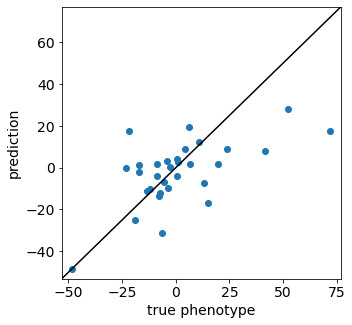

In [41]:
plt.figure(figsize = (5, 5))
plt.scatter(y_2W_te, y_2W_l1_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.ylim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.axline(xy1=[0, 0], slope=1, c="black")

## Elastic net

One solution to make the lasso more stable is to use a combination of the l1 and l2 regularizations.

We are now minimizing the loss + a linear combination of an l1-norm and an l2-norm over the regression weights. This imposes sparsity, but encourages correlated features to be selected together, where the lasso would tend to pick only one (at random) of a group of correlated features.

The elastic net is implemented in scikit-learn's [linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

### Regularization path

To better understand the difference between Lasso and Elastic net, we can start by visualizing the regularization path of a few variables for both models. To avoid looking at almost 10,000 paths (as many as SNPs), we'll only look at the paths for the features selected by the Lasso in the previous section (indexed by `selected_snps`).

The regularization path of a variable shows how the regression coefficient of this variable evolves as a function of the regularization parameter.

It can be computed with [linear_model.lasso_path](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html) for the Lasso and [linear_model.enet_path](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.enet_path.html) for Elastic net. For the Elastic net, we're fixing `l1_ratio`.

In [27]:
from sklearn import linear_model

In [28]:
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X_2W_tr[:, :], y_2W_tr, eps=1e-2, n_alphas=30, fit_intercept=True)

In [29]:
alphas_enet, coefs_enet, _ = linear_model.enet_path(X_2W_tr[:, :], y_2W_tr, eps=1e-2, n_alphas=30,  
                                                    l1_ratio=0.8, fit_intercept=True)

In [30]:
from itertools import cycle
import matplotlib.colors as mcolors

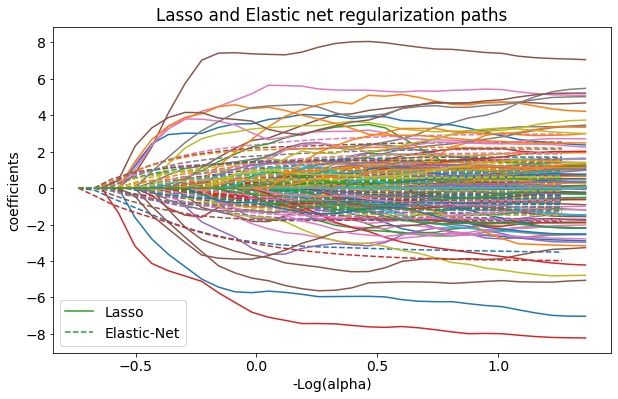

In [31]:
colors = cycle(list(mcolors.TABLEAU_COLORS.keys()))
figure(figsize = (10, 6))
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)

for coef_l, coef_e, c in zip(coefs_lasso[selected_snps, :], coefs_enet[selected_snps, :], colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c = c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle = '--', c = c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic net regularization paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

plt.show()

__Q: Compared to the lasso, what is the effect of the elastic-net on the coefficients?__

__A:__ The elastic-net induces more shrinkage than the lasso, but doesn't have as strong a selection effect. By selecting groups of correlated variables together, the elastic-net tends to shrink each of them more. However, the coefficients tend to be close to 0 without being exactly 0.

### Fitting an elastic-net

In [32]:
# Parameters grid
alphas = np.logspace(-0.01, 10., num=15)
ratios = np.linspace(0.7, 1., num=4)

__Q: Define the elastic net model (call it `model_l1l2`) using the functions `ElasticNet` and `GridSearchCV`.__

In [33]:
# Answer:
enet = linear_model.ElasticNet(fit_intercept=True, max_iter=6000)
model_l1l2 = model_selection.GridSearchCV(enet, 
                                          param_grid={'alpha': alphas, 'l1_ratio': ratios}, 
                                          scoring='explained_variance', verbose=1)
model_l1l2.fit(X_2W_tr, y_2W_tr)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=ElasticNet(max_iter=6000),
             param_grid={'alpha': array([9.77237221e-01, 5.06990708e+00, 2.63026799e+01, 1.36458314e+02,
       7.07945784e+02, 3.67282300e+03, 1.90546072e+04, 9.88553095e+04,
       5.12861384e+05, 2.66072506e+06, 1.38038426e+07, 7.16143410e+07,
       3.71535229e+08, 1.92752491e+09, 1.00000000e+10]),
                         'l1_ratio': array([0.7, 0.8, 0.9, 1. ])},
             scoring='explained_variance', verbose=1)

In [34]:
model_l1l2.best_params_

{'alpha': 0.9772372209558107, 'l1_ratio': 0.9}

### Interpretation

(0.0, 9419.0)

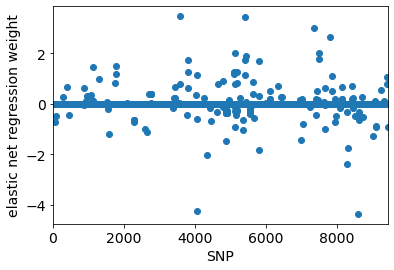

In [35]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1l2.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("elastic net regression weight")
plt.xlim([0, p])

In [36]:
selected_snps_enet = np.nonzero(model_l1l2.best_estimator_.coef_)[0]
print("%d SNPs selected," % selected_snps_enet.shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in selected_snps_enet:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1
            break

print("of which %d are in %d candidate genes" % (num_snps_in_candidate_genes, 
                                                          len(candidate_genes_hit)))

176 SNPs selected,
of which 176 are in 72 candidate genes


__Q: How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

__A:__ More SNPs are selected; but they are near slightly fewer genes. This illustrates that the elastic-net will favor shrinking correlated variables instead of selected out all but one (this is called the *grouping effect*).

### Predictive power 

In [37]:
from sklearn import metrics

In [38]:
y_2W_l1l2_pred = model_l1l2.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
      (selected_snps_enet.shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1l2_pred)))

Percentage of variance explained (using 176 SNPs): 0.22


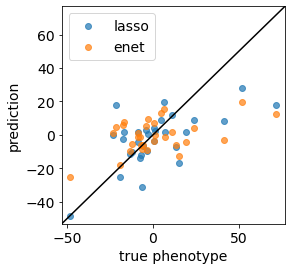

In [39]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_te, y_2W_l1_pred, alpha=0.7, label="lasso")
plt.scatter(y_2W_te, y_2W_l1l2_pred, alpha=0.7, label="enet")

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.ylim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.axline(xy1=[0, 0], slope=1, c="black")
plt.legend()